In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# 이미지 출력 함수

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

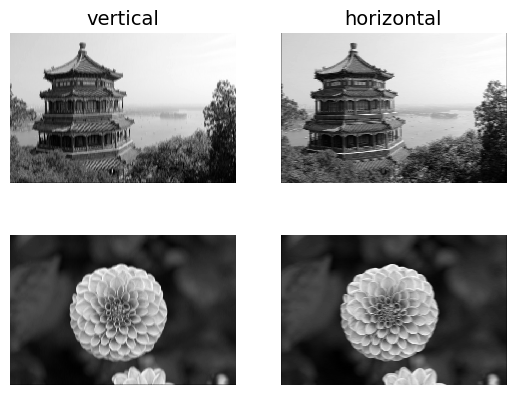

In [3]:
# 샘플 이미지를 로드

import numpy as np
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape # (2, 427, 640, 3)

# 수직 필터와 수평 필터 만들기
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        if image_index == 0:
            if feature_map_index:
                plt.title("horizontal", fontsize=14)
            else:
                plt.title("vertical", fontsize=14)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

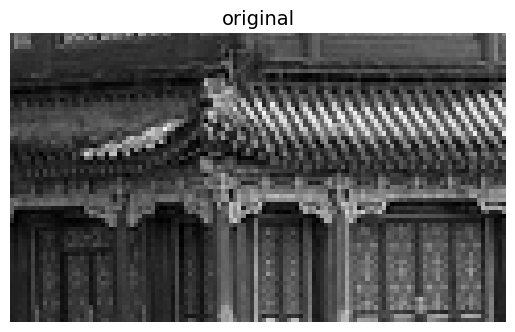

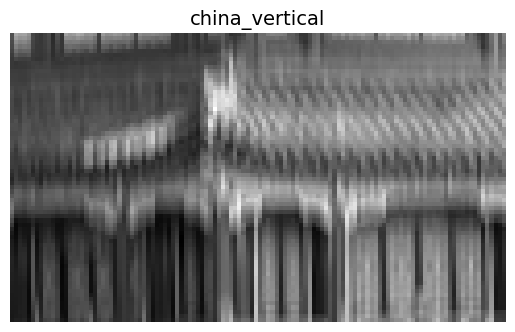

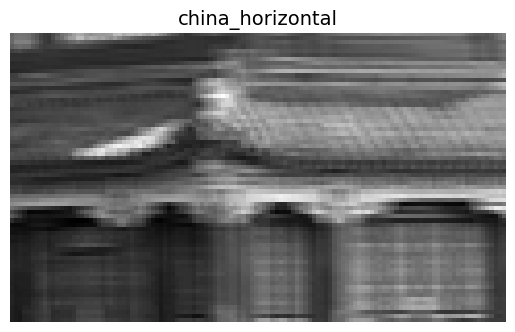

In [4]:
# 수평 필터와 수직 필터 비교

def crop(images):
    return images[150:220, 130:250]

plt.title("original", fontsize=14)
plot_image(crop(images[0, :, :, 0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plt.title(f"{filename}", fontsize=14)
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

위 결과를 통해 수직 필터를 사용한 경우 데이터의 수직 영역이 강조되어 표현되었고, 수평 필터를 사용한 경우 수평 영역이 강조되었다.

In [5]:
# 합성곱

conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
                           padding="SAME", activation="relu", input_shape=outputs.shape)

conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])

출력의 차원은 배치 크기, 높이, 너비, 채널 이렇게 4차원이다.

2개의 이미지를 입력으로 사용했기 때문에 배치 크기는 2이다.

그리고 padding="SAME"으로 하고, strides=1로 설정했기 때문에 출력 특성맵의 높이와 너비는 입력 이미지와 같아 각각 427, 640이다.

 마지막으로 수직과 수평 2개의 필터를 사용하여 마지막 차원의 크기는 2이다.

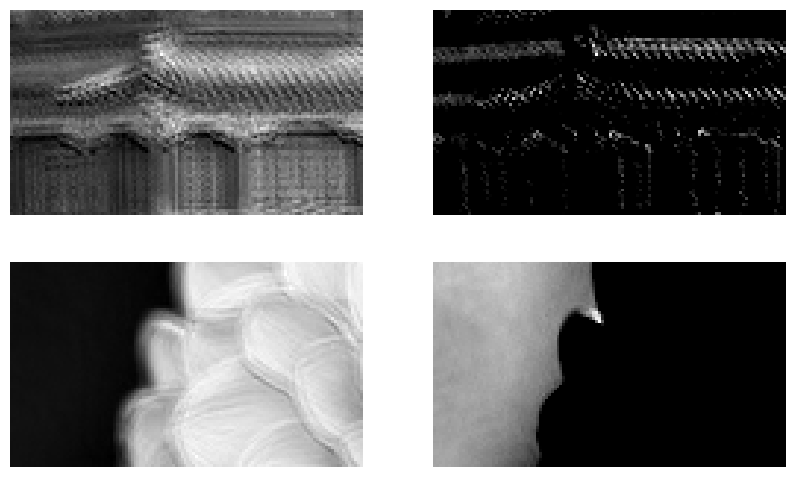

In [6]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

초기에는 필터가 랜덤하게 초기화되어 위와 같이 감지가 대략적으로 밖에 되지 않는다.

만약 사용자가 수동으로 필터를 정의하고 편향을 0으로 지정하면 아래와 같이 결과가 나온다.

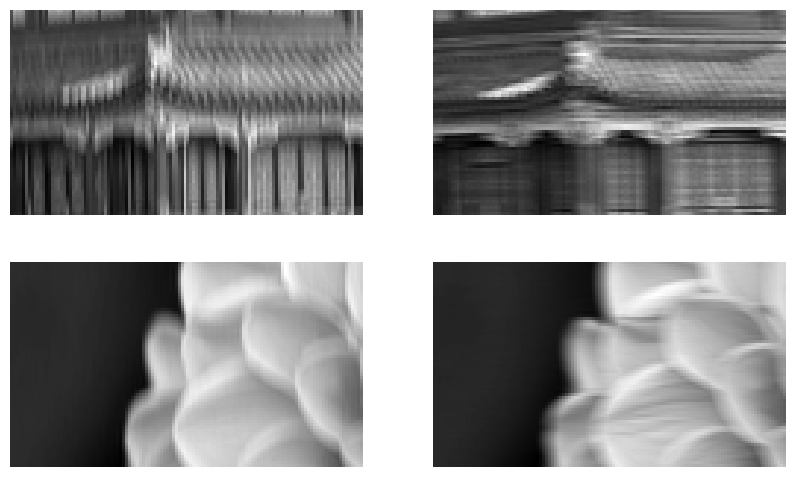

In [7]:
# 수직& 수평 필터 사용

conv.set_weights([filters, np.zeros(2)])
conv_outputs = conv(images)

plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

padding에서 VALID를 사용하게 되면 합성곱 층에 제로 패딩을 사용하지 않는다.

즉, 모든 뉴런의 수용장이 입력 안쪽 영역에만 놓인다는 의미이다.

하지만 SAME을 사용하게 된다면 필요한 경우 합성곱 층에 제로 패딩을 사용한다.

In [8]:
# padding

def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding == "SAME":
        return (input_size - 1) // strides + 1
    else:
        return (input_size - kernel_size) // strides + 1

def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

In [9]:
# keras의 padding과 구현한 padding이 같은지 확인

kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

conv_same.build(tf.TensorShape(images.shape))

conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

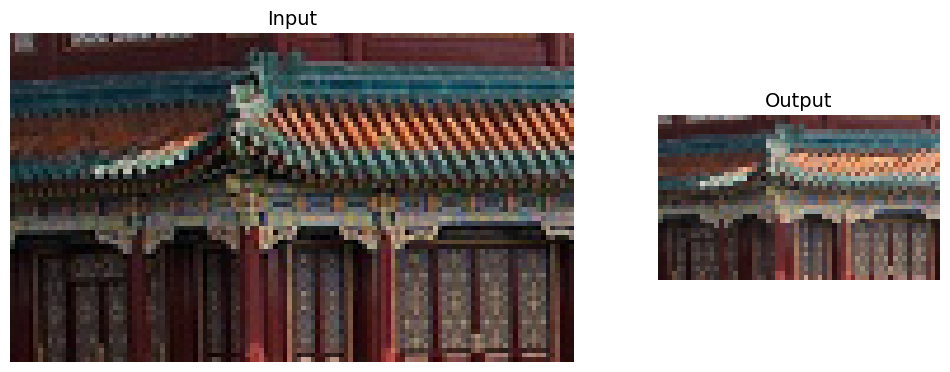

In [10]:
# 2 X 2 커널을 사용해서 최대 풀링

max_pool = keras.layers.MaxPool2D(pool_size=2)

cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])
ax2.axis("off")
plt.show()

깊이 방향 풀링은 주로 특성 맵의 깊이(채널 수) 방향에 대해 작동한다.

이는 특성 맵의 높이와 너비를 줄이지 않고, 채널의 차원을 감소시켜 모델의 파라미터 수와 연산량을 줄이는 데 도움을 준다.

그리고 깊이 방향 풀링은 각 채널에 대한 정보를 요약하고 중요한 정보를 강조하는 역할을 하기 때문에 CNN에서 불변성을 학습할 수 있다.

In [11]:
# 깊이 방향 풀링

class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [12]:
depth_pool = DepthMaxPool(3)

# 깊이 방향 풀링은 CPU에서만 동작한다
with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

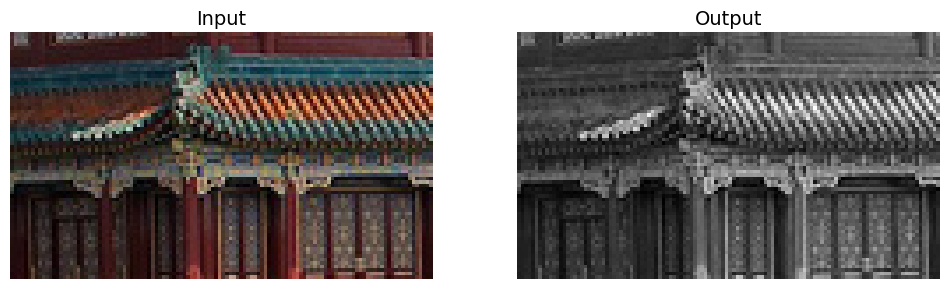

In [13]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])

plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0])
plt.axis("off")
plt.show()

In [14]:
# Lambda를 이용해서 깊이 방향 풀링

depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

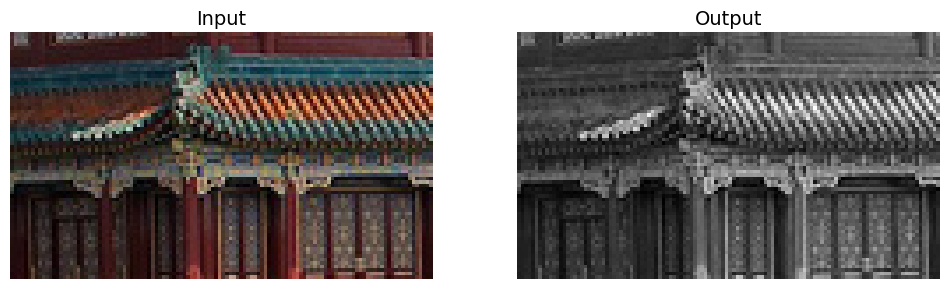

In [15]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])

plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0])
plt.axis("off")
plt.show()

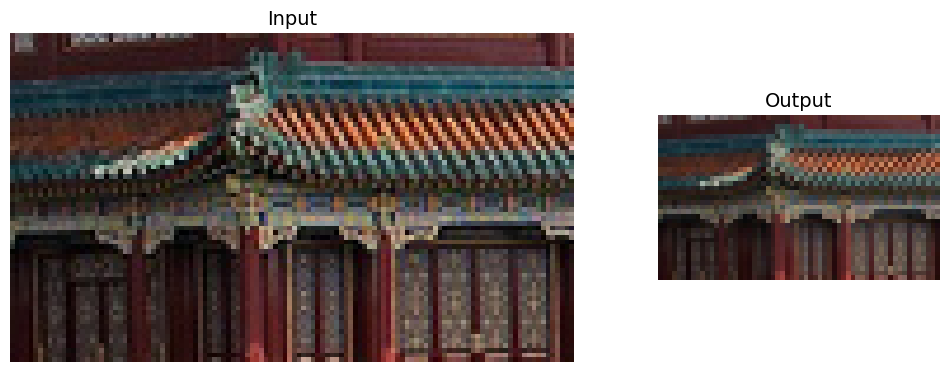

In [16]:
# 평균 풀링

avg_pool = keras.layers.AvgPool2D(pool_size=2)
output_avg = avg_pool(cropped_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])
ax2.axis("off")

plt.show()

전역 평균 풀링은 다른 층과는 다르게 각 특성 맵의 평균을 계산하는 작동을 하여 각 특성 맵마다 하나의 숫자를 출력한다.

In [17]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45952243, 0.33423486]], dtype=float32)>

In [18]:
# Lambda를 이용해서 전역 평균 풀링층 구하기

output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45952243, 0.33423486]], dtype=float32)>

In [19]:
# CNN으로 패션 MNIST 문제 풀기

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

# 학습을 위해 채널 차원 추가
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

4422102/4422102 [==============================] - 1s 0us/step


아래는 간단한 CNN코드로 첫 번째 층은 64개의 7 X 7의 큰 필터로 학습을 한다.

그 다음 크기가 2인 최대 풀링으로 공간 방향 차원을 절반으로 감소한다.

학습을 하면 할수록 점점 고수준 특성이 만들어지기 때문에 필터의 수를 늘려가면서 위와 같은 모델을 반복한다.

밀집 네트워크는 샘플의 특성이 1차원이므로 입력을 일렬로 펼친후 2개의 은닉층과 하나의 출력층으로 구성된 완전 연결 네트워크를 통과한다.

또한 밀집 층 사이에 과대적합을 줄이기 위해 50%의 드롭아웃층을 추가한다.

In [20]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [21]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # 새로운 이미지처럼 사용합니다
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 33s 14ms/step - loss: 0.7225 - accuracy: 0.7479 - val_loss: 0.3960 - val_accuracy: 0.8608
Epoch 2/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.4389 - accuracy: 0.8565 - val_loss: 0.3289 - val_accuracy: 0.8814
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3748 - accuracy: 0.8747 - val_loss: 0.3048 - val_accuracy: 0.8900
Epoch 4/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3428 - accuracy: 0.8854 - val_loss: 0.3160 - val_accuracy: 0.8894
Epoch 5/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3184 - accuracy: 0.8930 - val_loss: 0.2776 - val_accuracy: 0.9010
Epoch 6/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3067 - accuracy: 0.8961 - val_loss: 0.2763 - val_accuracy: 0.9044
Epoch 7/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2841 - accuracy: 0.9049 - val_loss: 0.2968 - val_

In [22]:
# ResNet-34

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []

        # 특성 맵 수가 다른경우만 stride를 통한 변형이 필요함
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [23]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:

    # 이전과 필터 수가 동일한 경우 stride = 1 아니면 2
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (Batch  (None, 112, 112, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 residual_unit (ResidualUni  (None, 56, 56, 64)        74240     
 t)                                                              
                                                      

In [24]:
# 사전 훈련된 모델 사용 - (ResNet-50 모델)

model = keras.applications.resnet50.ResNet50(weights="imagenet")

102967424/102967424 [==============================] - 3s 0us/step


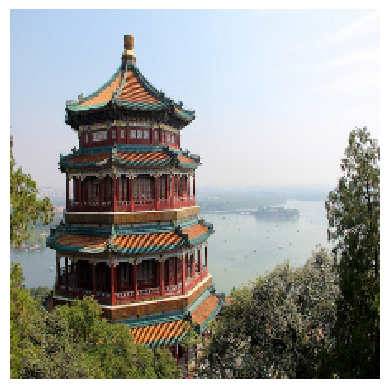

In [25]:
# ResNet-50모델에 맞춰 이미지 크기 변환

images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

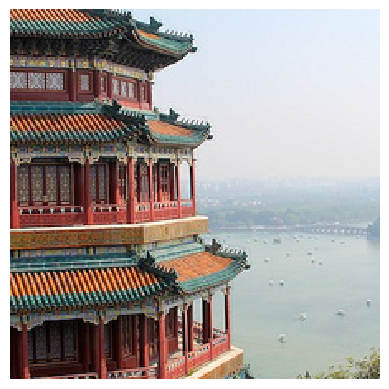

In [26]:
# 이미지 가로세로 비율 유지하여 자르기

images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

In [27]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255) # 이미지 사이즈 다시 픽셀값으로 바꾸기
Y_proba = model.predict(inputs)

1/1 [==============================] - 2s 2s/step


In [28]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index + 1))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

35363/35363 [==============================] - 0s 0us/step
Image #1
  n03877845 - palace       92.32%
  n03781244 - monastery    5.34%
  n02825657 - bell_cote    0.95%

Image #2
  n04522168 - vase         38.44%
  n07930864 - cup          8.86%
  n11939491 - daisy        8.10%



모델은 총 1000개의 클래스가 있는데 이중에서 첫 번째 그림은 궁전으로, 두 번째 그림은 화분으로 인식하였다.

정답인 monastery와 daisy도 top3안에 포함되어있으므로 상당히 잘 예측했음을 볼 수 있다.

In [29]:
# 전이 학습으로 모델 학습

import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [31]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [49]:
n_classes = info.features["label"].num_classes
n_classes

5

In [33]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [44]:
# 테스트 세트: 10%, 검증 세트: 15%, 훈련 세트: 75%로 데이터 분할

test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

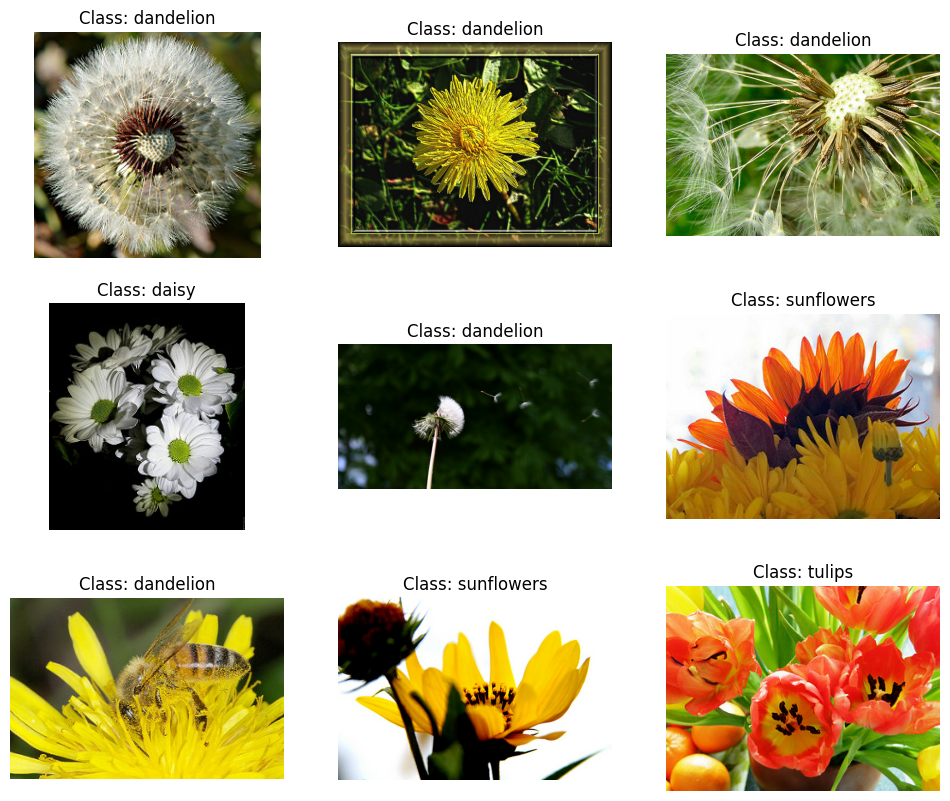

In [45]:
# 처음 9개의 이미지 출력

plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

전이 학습을 하기 위해 요구하는 이미지의 크기를 맞추기 위해 이미지 크기를 224 X 224로 조정해야한다.

In [46]:
# 이미지 조정 및 데이터 증대

# 이미지의 중심만 남김
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

# 이미지를 랜덤하게 자름
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

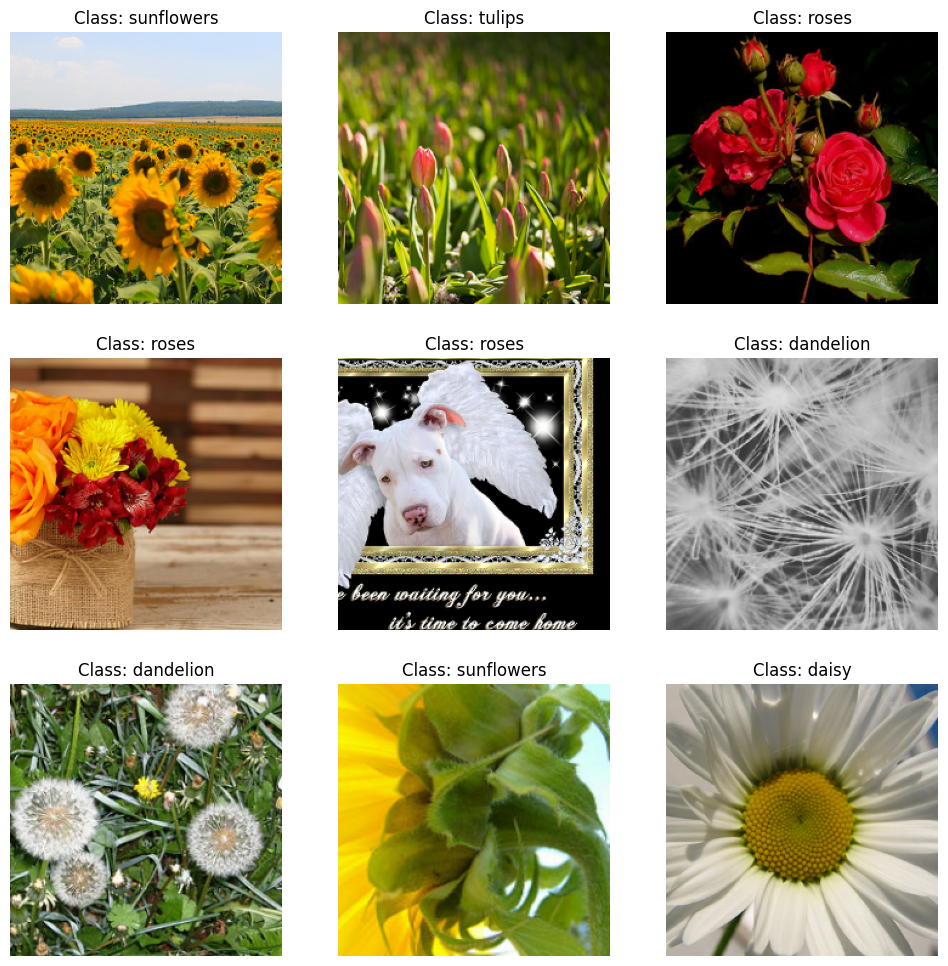

In [47]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [48]:
# 이미지넷에서 사전 훈련된 Xception모델 로드

base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False) # 네트워크 최상층의 전역 평균 풀링층과 밀집 출력층 제외시킴
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83683744/83683744 [==============================] - 3s 0us/step


In [50]:
 # 훈련 초기 가중치 동결
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, weight_decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 22s 195ms/step - loss: 1.3543 - accuracy: 0.7929 - val_loss: 1.8913 - val_accuracy: 0.7904
Epoch 2/5
86/86 [==============================] - 15s 180ms/step - loss: 0.9282 - accuracy: 0.8703 - val_loss: 1.2601 - val_accuracy: 0.8272
Epoch 3/5
86/86 [==============================] - 15s 173ms/step - loss: 0.5436 - accuracy: 0.9023 - val_loss: 1.2678 - val_accuracy: 0.8217
Epoch 4/5
86/86 [==============================] - 15s 173ms/step - loss: 0.6537 - accuracy: 0.8841 - val_loss: 1.0119 - val_accuracy: 0.8327
Epoch 5/5
86/86 [==============================] - 15s 174ms/step - loss: 0.4868 - accuracy: 0.9073 - val_loss: 1.2642 - val_accuracy: 0.8235


모델의 검증 정확도가 횡보하고 있으므로 추가된 최상위 층이 잘 훈련되었다는 것을 의미한다.

따라서 동결을 해제하고 훈련을 계속 진행한다.

이때 사전 훈련된 가중치가 훼손되는 것을 줄이기 위해 작은 학습률을 사용해야한다.

In [51]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, weight_decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 70s 570ms/step - loss: 0.3880 - accuracy: 0.8837 - val_loss: 0.5310 - val_accuracy: 0.8732
Epoch 2/40
86/86 [==============================] - 47s 546ms/step - loss: 0.1533 - accuracy: 0.9586 - val_loss: 0.3365 - val_accuracy: 0.8824
Epoch 3/40
86/86 [==============================] - 47s 551ms/step - loss: 0.0801 - accuracy: 0.9760 - val_loss: 0.3331 - val_accuracy: 0.8915
Epoch 4/40
86/86 [==============================] - 47s 551ms/step - loss: 0.0569 - accuracy: 0.9829 - val_loss: 0.2735 - val_accuracy: 0.9173
Epoch 5/40
86/86 [==============================] - 47s 548ms/step - loss: 0.0370 - accuracy: 0.9909 - val_loss: 0.2775 - val_accuracy: 0.9228
Epoch 6/40
86/86 [==============================] - 47s 547ms/step - loss: 0.0425 - accuracy: 0.9858 - val_loss: 0.2946 - val_accuracy: 0.9191
Epoch 7/40
86/86 [==============================] - 47s 550ms/step - loss: 0.0287 - accuracy: 0.9916 - val_loss: 0.2970 - val_accuracy: 0.9283

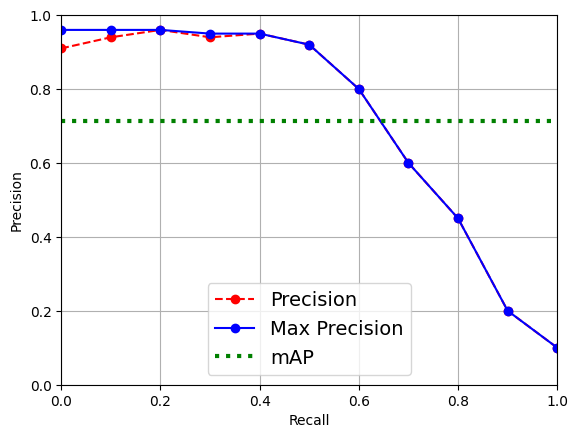

In [53]:
# mAP구하기

def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

recalls = np.linspace(0, 1, 11)
precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()

전치 합성곱은 CNN에서 입력 데이터의 공간적 차원을 확장하는 데 사용된다.

이는 업스케일링을 통해 출력 특성 맵의 크기를 키우고 상세한 정보를 재구성 한다.

일반적으로 컨볼루션 층을 거친 후 특성 맵의 크기가 줄어들게 되는데, 이후의 층에서 동일한 크기로 복원하려면 전치 합성곱을 사용해야한다.

In [54]:
# 전치 합성곱

X = images_resized.numpy()

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding="VALID")
output = conv_transpose(X)
output.shape

TensorShape([2, 449, 449, 5])

In [60]:
# 업스케일링

def upscale_images(images, stride, kernel_size):
    batch_size, height, width, channels = images.shape
    upscaled = np.zeros((batch_size,
                         (height - 1) * stride + 2 * kernel_size - 1,
                         (width - 1) * stride + 2 * kernel_size - 1,
                         channels))
    upscaled[:,
             kernel_size - 1:(height - 1) * stride + kernel_size:stride,
             kernel_size - 1:(width - 1) * stride + kernel_size:stride,
             :] = images
    return upscaled

def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

In [61]:
upscaled = upscale_images(X, stride=2, kernel_size=3)
weights, biases = conv_transpose.weights
reversed_filters = np.flip(weights.numpy(), axis=[0, 1])
reversed_filters = np.transpose(reversed_filters, [0, 1, 3, 2])
manual_output = tf.nn.conv2d(upscaled, reversed_filters, strides=1, padding="VALID")

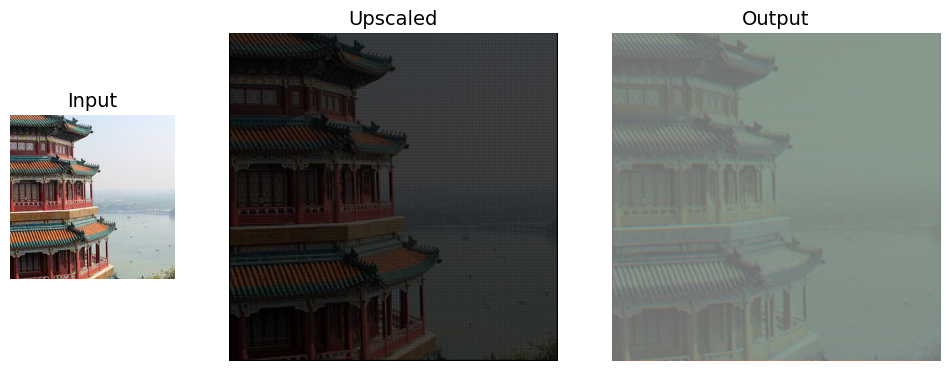

In [62]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 2, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Upscaled", fontsize=14)
ax2.imshow(upscaled[0], interpolation="bicubic")
ax2.axis("off")

ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Output", fontsize=14)
ax3.imshow(normalize(manual_output[0, ..., :3]), interpolation="bicubic")
ax3.axis("off")

plt.show()